# 

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from scipy.special import expit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
gss = utils.ReadGss('gss_college_religion')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [3]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [4]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [5]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [6]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

In [7]:
utils.values(gss, 'age')

18.0     219
19.0     831
20.0     870
21.0     985
22.0    1037
23.0    1203
24.0    1171
25.0    1332
26.0    1301
27.0    1350
28.0    1380
29.0    1279
30.0    1394
31.0    1303
32.0    1381
33.0    1329
34.0    1351
35.0    1335
36.0    1314
37.0    1312
38.0    1305
39.0    1181
40.0    1238
41.0    1178
42.0    1156
43.0    1196
44.0    1129
45.0    1056
46.0    1075
47.0    1073
        ... 
60.0     890
61.0     800
62.0     837
63.0     798
64.0     702
65.0     776
66.0     709
67.0     771
68.0     698
69.0     648
70.0     669
71.0     588
72.0     592
73.0     532
74.0     560
75.0     478
76.0     487
77.0     447
78.0     420
79.0     365
80.0     323
81.0     320
82.0     264
83.0     253
84.0     215
85.0     185
86.0     171
87.0     143
88.0     113
89.0     331
Name: age, dtype: int64

{'xscale': 'linear', 'yscale': 'linear'}

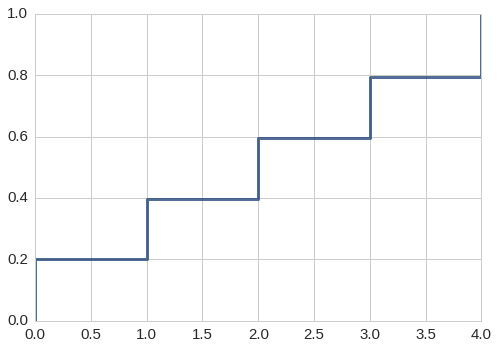

In [8]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5)
thinkplot.Cdf(thinkstats2.Cdf(gss.age - gss.age_group))

In [9]:
utils.values(gss, 'cohort')

1883.0      2
1884.0      3
1885.0      7
1886.0      4
1887.0     13
1888.0     10
1889.0     21
1890.0     27
1891.0     27
1892.0     31
1893.0     34
1894.0     61
1895.0     55
1896.0     73
1897.0     72
1898.0    104
1899.0    123
1900.0    130
1901.0    137
1902.0    163
1903.0    173
1904.0    182
1905.0    217
1906.0    207
1907.0    261
1908.0    246
1909.0    330
1910.0    285
1911.0    318
1912.0    345
         ... 
1969.0    785
1970.0    796
1971.0    658
1972.0    635
1973.0    609
1974.0    591
1975.0    530
1976.0    522
1977.0    535
1978.0    453
1979.0    490
1980.0    447
1981.0    425
1982.0    357
1983.0    325
1984.0    309
1985.0    308
1986.0    249
1987.0    233
1988.0    181
1989.0    200
1990.0    134
1991.0    140
1992.0     92
1993.0     92
1994.0     80
1995.0     58
1996.0     32
1997.0     33
1998.0      7
Name: cohort, dtype: int64

{'xscale': 'linear', 'yscale': 'linear'}

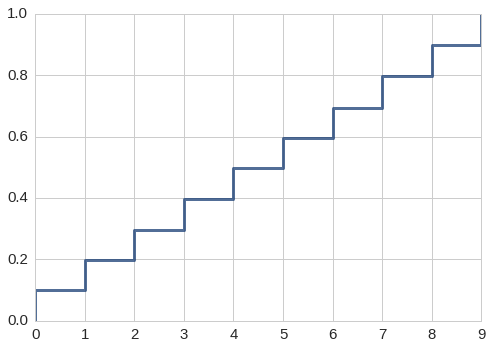

In [10]:
gss['decade'] = utils.RoundIntoBins(gss, 'cohort', 10)
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort - gss.decade))

In [11]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5) + 2.5

Religion code 4 represents people who report no religious affiliation.

In [12]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

In [13]:
gss['none'] = (gss.relig==4).astype(int)
gss['cath'] = (gss.relig==2).astype(int)

# the second line lumps "Orthodox-Christian" and "Christian" with Protestant
gss['prot'] = (gss.relig==1).astype(int)
gss['prot'] = (gss.relig.isin([1,10,11])).astype(int)

gss['other'] = (gss.relig.isin([3,5,6,7,8,9,10,11,12,13])).astype(int)

In [14]:
gss['relig2'] = gss.relig.copy()
gss.loc[gss.relig>4, 'relig2'] = 3
utils.values(gss, 'relig2')

1.0    35856
2.0    15136
3.0     3772
4.0     7231
Name: relig2, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [15]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god,age_group,decade,cohort5,none,cath,prot,other,relig2
0,1972,0,0,1895.0,77.0,1.3339,0,1.0,5,659,0,75.0,1890.0,1897.5,0,0,1,0,1.0
1,1972,0,0,1909.0,63.0,0.8893,0,1.0,8,1531,0,60.0,1900.0,1907.5,0,0,1,0,1.0
2,1972,0,0,1949.0,23.0,0.8893,0,1.0,16,1250,0,20.0,1940.0,1947.5,0,0,1,0,1.0
3,1972,0,0,1943.0,29.0,0.4446,0,1.0,13,599,0,25.0,1940.0,1942.5,0,0,1,0,1.0
4,1972,0,0,1907.0,65.0,1.3339,0,1.0,6,1196,0,65.0,1900.0,1907.5,0,0,1,0,1.0


## How does religious affiliation change with age?

Group by decade of birth and age group.

In [16]:
grouped = sample.groupby(['decade', 'age_group'])

Count the number of observations in each decade/age group.

In [17]:
counts = grouped.none.count().unstack()
counts

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,37.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,182.0,149.0,109.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,402.0,510.0,308.0,235.0,138.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,604.0,766.0,720.0,639.0,459.0,241.0,210.0
1920.0,NaN,NaN,NaN,NaN,NaN,90.0,713.0,1025.0,910.0,900.0,764.0,639.0,423.0,268.0,181.0
1930.0,NaN,NaN,NaN,78.0,646.0,970.0,922.0,955.0,819.0,682.0,599.0,499.0,393.0,171.0,23.0
1940.0,NaN,125.0,854.0,1214.0,1116.0,1339.0,1279.0,1206.0,1011.0,946.0,648.0,274.0,42.0,NaN,NaN
1950.0,309.0,1445.0,1639.0,1686.0,1627.0,1677.0,1523.0,1336.0,1081.0,566.0,75.0,NaN,NaN,NaN,NaN
1960.0,331.0,1578.0,1472.0,1658.0,1541.0,1480.0,1050.0,668.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600000,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020833,0.032967,0.026846,0.018349
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017241,0.022388,0.037255,0.038961,0.046809,0.036232
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063158,0.029801,0.040470,0.030556,0.057903,0.019608,0.037344,0.057143
1920.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.035063,0.024390,0.046154,0.024444,0.036649,0.048513,0.068558,0.059701,0.082873
1930.0,NaN,NaN,NaN,0.051282,0.043344,0.039175,0.058568,0.053403,0.032967,0.054252,0.061770,0.056112,0.050891,0.058480,0.000000
1940.0,NaN,0.136000,0.126464,0.079077,0.096774,0.065721,0.087568,0.067993,0.102868,0.117336,0.112654,0.120438,0.190476,NaN,NaN
1950.0,0.103560,0.118339,0.123246,0.090154,0.098341,0.124031,0.133290,0.127994,0.148936,0.144876,0.146667,NaN,NaN,NaN,NaN
1960.0,0.163142,0.115336,0.122283,0.135103,0.173264,0.133784,0.173333,0.175150,0.153061,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [19]:
percent_none[counts < 50] = np.nan

In [20]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.051282,0.043344,0.039175,0.058568,0.053403,0.032967,0.054252,0.061770,0.056112,0.050891,0.05848,NaN
1940.0,NaN,0.136000,0.126464,0.079077,0.096774,0.065721,0.087568,0.067993,0.102868,0.117336,0.112654,0.120438,NaN,NaN,NaN
1950.0,0.103560,0.118339,0.123246,0.090154,0.098341,0.124031,0.133290,0.127994,0.148936,0.144876,0.146667,NaN,NaN,NaN,NaN
1960.0,0.163142,0.115336,0.122283,0.135103,0.173264,0.133784,0.173333,0.175150,0.153061,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.188153,0.180484,0.189824,0.229447,0.179174,0.223127,0.151163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.249249,0.271563,0.285583,0.264706,0.231481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


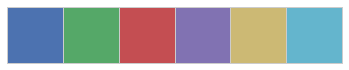

In [21]:
colors = sns.color_palette()
sns.palplot(colors)

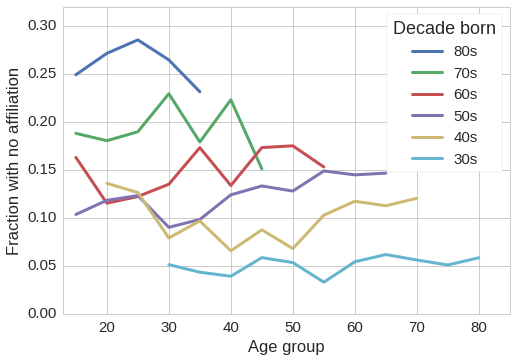

In [22]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

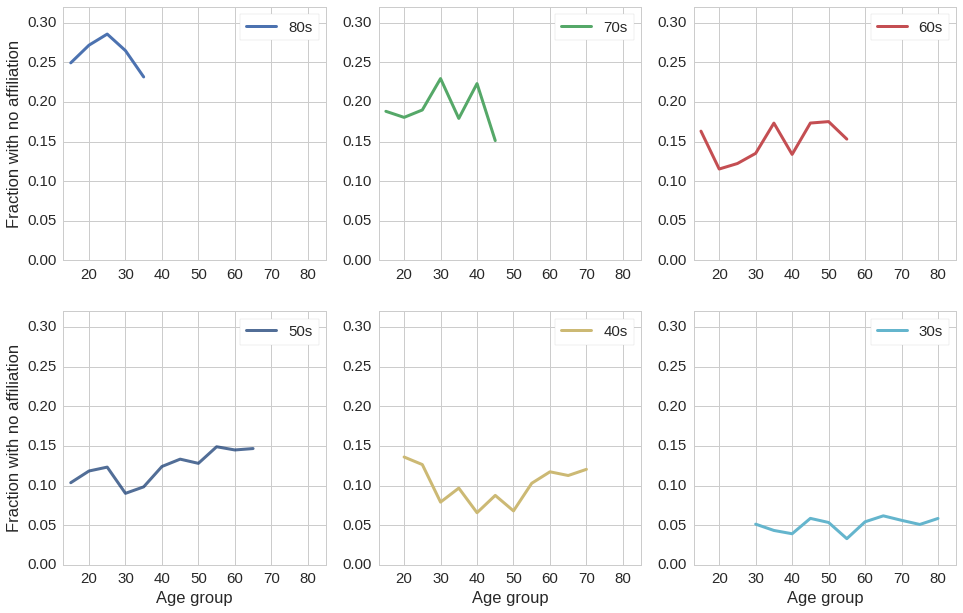

In [23]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [24]:
sample['age_group10'] = utils.RoundIntoBins(sample, 'age', 10)

In [25]:
sample['year4'] = utils.RoundIntoBins(sample, 'year', 4, low=2)

In [26]:
grouped = sample.groupby(['age_group10', 'year4'])

In [27]:
counts = grouped.none.count().unstack()
counts

year4,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014
age_group10,,,,,,,,,,,,
10.0,86,192,76,184,153,70,116,127,122,150,76,118
20.0,718,1454,759,1602,1426,911,1103,1082,1115,1152,675,944
30.0,510,1104,611,1367,1347,1042,1432,1273,1104,1219,749,966
40.0,613,972,474,972,1119,944,1239,1181,1174,1396,754,905
50.0,568,989,431,951,783,542,855,814,905,1168,759,1043
60.0,357,738,371,748,765,474,548,526,570,714,555,760
70.0,205,396,203,423,506,371,434,412,354,460,262,390
80.0,42,122,53,156,169,118,143,182,183,213,160,226


## Changes within age groups

In [28]:
percent_none = grouped.none.mean().unstack()
percent_none[counts < 50] = np.nan
percent_none*=100
percent_none

year4,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014
age_group10,,,,,,,,,,,,
10.0,8.139535,10.937500,11.842105,13.043478,21.568627,12.857143,24.137931,22.047244,22.131148,26.000000,23.684211,38.983051
20.0,13.370474,12.585970,12.121212,11.985019,10.799439,9.220637,15.775159,21.811460,22.331839,24.479167,30.814815,30.826271
30.0,4.901961,6.884058,9.492635,8.705194,9.725316,9.500960,11.103352,17.674784,16.757246,19.196062,20.560748,27.743271
40.0,2.283850,4.835391,5.063291,5.246914,5.630027,8.262712,12.510089,14.648603,11.754685,14.326648,18.832891,19.116022
50.0,4.577465,2.022245,3.016241,4.416404,4.853129,4.797048,4.444444,9.213759,9.944751,13.955479,14.756258,16.874401
60.0,1.680672,3.387534,4.851752,2.540107,2.745098,3.586498,4.744526,5.323194,7.894737,11.204482,13.873874,13.421053
70.0,2.439024,4.040404,2.955665,2.600473,4.545455,5.660377,3.456221,6.553398,6.497175,7.173913,5.725191,9.743590
80.0,NaN,2.459016,0.000000,2.564103,5.325444,3.389831,2.097902,4.395604,7.103825,6.572770,7.500000,5.752212


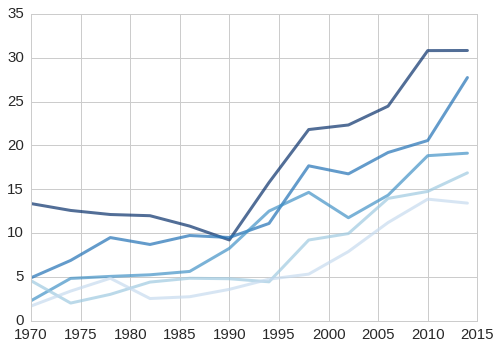

In [29]:
rows = percent_none.loc[20:65]
for age_group, row in rows.iterrows():
    thinkplot.plot(row)

In [30]:
row

year4
1970     1.680672
1974     3.387534
1978     4.851752
1982     2.540107
1986     2.745098
1990     3.586498
1994     4.744526
1998     5.323194
2002     7.894737
2006    11.204482
2010    13.873874
2014    13.421053
Name: 60.0, dtype: float64

In [31]:
def FitRow(row, formula='y ~ time + time2'):
    """Fits a model to a Series.
    
    row: Series
    formula: Patsy string
    
    returns: RegressionResults
    """

    time = row.index
    time -= min(time)
    time2 = time**2
    
    df = pd.DataFrame(dict(time=time, time2=time2, y=row))
    results = smf.ols(formula, data=df).fit()
    return results

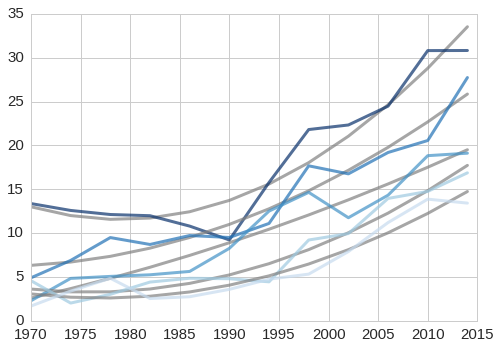

In [32]:
for age_group, row in rows.iterrows():
    results = FitRow(row)
    thinkplot.plot(results.fittedvalues, color='gray')
    thinkplot.plot(row)

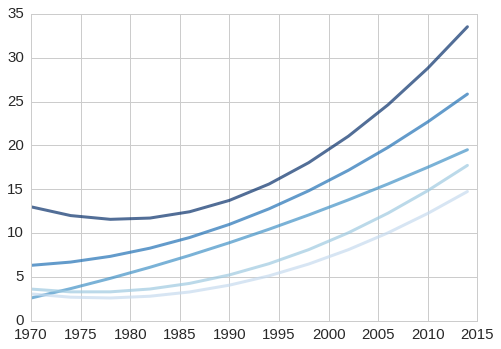

In [33]:
for age_group, row in rows.iterrows():
    results = FitRow(row)
    ys = results.fittedvalues
    thinkplot.plot(ys)

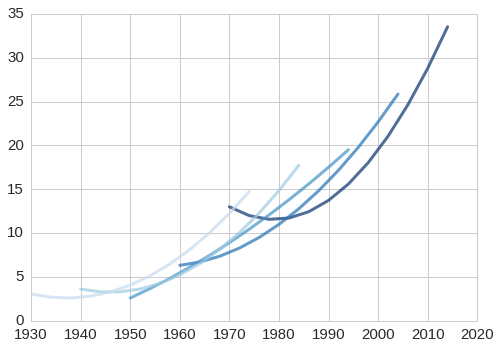

In [34]:
shift = 0
for age_group, row in rows.iterrows():
    results = FitRow(row)
    ys = results.fittedvalues
    ys.index -= shift
    shift += 10
    thinkplot.plot(ys)

In [35]:
heri = pd.read_csv('heri17.csv', skiprows=2, index_col='year')
heri[heri.columns] /= 10
heri.tail()

,noneall,fatherall,motherall,attendedall,nonemen,fathermen,mothermen,attendedmen,nonewomen,fatherwomen,motherwomen,attendedwomen,bornagain,evangelical
year,,,,,,,,,,,,,,
2012,23.8,16.8,11.8,73.2,26.3,16.4,11.9,70.7,21.7,17.1,11.7,75.4,20.2,8.5
2013,24.6,17.1,12.1,72.7,26.9,16.2,12.0,70.3,22.6,17.9,12.1,74.8,NaN,NaN
2014,27.5,19.0,13.8,70.7,30.0,18.4,13.7,68.3,25.4,19.5,13.9,72.7,NaN,NaN
2015,29.6,16.6,16.4,69.5,31.8,NaN,NaN,67.8,27.7,NaN,NaN,70.8,NaN,NaN
2016,30.9,NaN,NaN,68.9,33.1,NaN,NaN,67.1,29.1,NaN,NaN,70.4,NaN,NaN


In [36]:
heri['time'] = heri.index - 1966
heri['time2'] = heri.time**2

20.0
30.0
40.0
50.0
60.0


thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


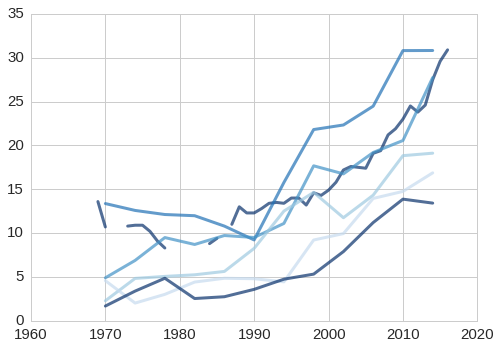

In [37]:
thinkplot.plot(heri.noneall)

for age_group, row in rows.iterrows():
    print(age_group)
    #results = FitRow(row)
    #thinkplot.plot(results.fittedvalues, color='gray')
    thinkplot.plot(row)

## Generational replacement

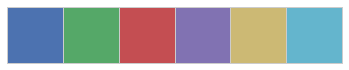

In [38]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(colors)

In [39]:
def plot_grouped(grouped):
    percent_other = grouped.other.mean() * 100
    percent_none = grouped.none.mean() * 100
    percent_prot = grouped.prot.mean() * 100
    percent_cath = grouped.cath.mean() * 100
    
    thinkplot.plot(percent_prot, color=ORANGE, label='Protestant')
    thinkplot.plot(percent_cath, color=GREEN, label='Catholic')
    thinkplot.plot(percent_none, color=RED, label='None')
    thinkplot.plot(percent_other, color=BLUE, label='Other')

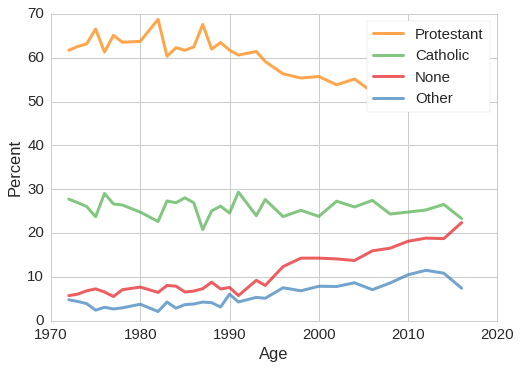

In [40]:
grouped1 = sample.groupby(['year'])
plot_grouped(grouped1)
thinkplot.config(xlabel='Age', ylabel='Percent')

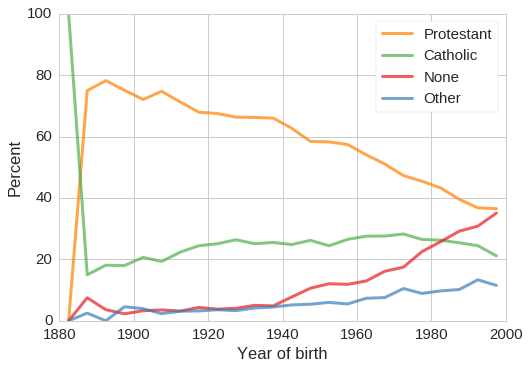

In [41]:
grouped2 = sample.groupby(['cohort5'])
plot_grouped(grouped2)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

In [42]:
def percent_relig(df):
    """Compute the fraction in each major religious group.
    
    df: DataFrame
    
    returns: Series that maps from group name to percent.
    """
    return df[['prot', 'cath', 'none']].mean()

In [43]:
percent_relig(sample[sample.year==2016])

prot    0.489257
cath    0.233181
none    0.224023
dtype: float64

To simulate generation replacement, start with a cohort from the last few cycles.

In [44]:
recent = sample.loc[sample.year>=2000].copy()
recent.shape

(24146, 21)

In [45]:
percent_relig(recent)

prot    0.524435
cath    0.256026
none    0.168185
dtype: float64

In [46]:
recent.year.mean()

2007.6164996272676

{'xscale': 'linear', 'yscale': 'linear'}

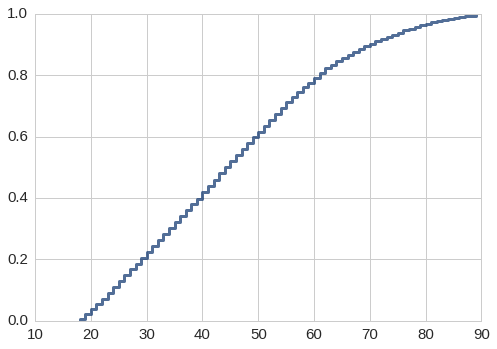

In [47]:
thinkplot.Cdf(thinkstats2.Cdf(recent.age))

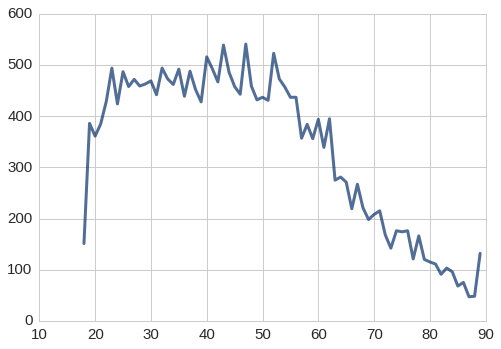

In [48]:
hist = thinkstats2.Hist(recent.age)
thinkplot.Pdf(hist)

In [49]:
def advance(df):
    """Ages a cohort by 1 year.
    
    df: DataFrame
    
    returns: new DataFrame
    """
    new = df.copy()
    new.year += 1
    new.age += 1
    
    return new

In [50]:
df = recent
pr = percent_relig(recent)
series = pd.DataFrame(columns=pr.index)

for _ in range(10):
    df = advance(df)
    year = df.year.mean()
    series.loc[year] = percent_relig(df)

In [51]:
series

,prot,cath,none
2008.6165,0.524435,0.256026,0.168185
2009.6165,0.524435,0.256026,0.168185
2010.6165,0.524435,0.256026,0.168185
2011.6165,0.524435,0.256026,0.168185
2012.6165,0.524435,0.256026,0.168185
2013.6165,0.524435,0.256026,0.168185
2014.6165,0.524435,0.256026,0.168185
2015.6165,0.524435,0.256026,0.168185
2016.6165,0.524435,0.256026,0.168185
2017.6165,0.524435,0.256026,0.168185


In [52]:
updated = advance(recent)

In [53]:
# https://www.cdc.gov/nchs/data/dvs/mortfinal2007_worktable23r.pdf

AGES = np.array([24, 34, 44, 54, 64, 74, 84])
RATES = np.array([79.9, 104.9, 184.4, 420.9, 877.7, 2011.3, 5011.6, 12946.5]) / 100000

In [54]:
def choose_dead(df):
    """Simulate deaths based on age-related rates.
    
    df: DataFrame
    
    returns: boolean array with True for dead
    """
    
    # look up the death rate for each respondent
    indices = np.searchsorted(AGES, df.age)
    rates = RATES[indices]
    
    # choose who dies
    dead = np.random.random(len(rates)) < rates
    return dead

In [55]:
dead = choose_dead(updated)
dead.sum()

231

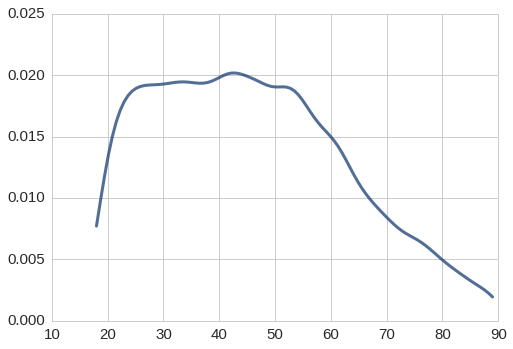

In [56]:
pdf = thinkstats2.EstimatedPdf(recent.age)
thinkplot.Pdf(pdf)

In [57]:
def replace(df, pdf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = np.nan
    
    pdf2 = thinkstats2.EstimatedPdf(updated.age.dropna())
    ages = np.arange(17, 92, 1)
    diffs = pdf.Density(ages) - pdf2.Density(ages)
    diffs[diffs<0] = 0
    pmf = thinkstats2.Pmf(dict(zip(ages, diffs)))
    thinkplot.Pdf(pmf)
    replacement_ages = pmf.Sample(dead.sum())
    updated.loc[dead, 'age'] = replacement_ages
    
    return updated

In [58]:
def replace(df, pmf):
    updated = advance(df)
    dead = choose_dead(updated)
    updated.loc[dead, 'age'] = 18
    updated['weight'] = pmf.Probs(updated.age.values)
    sample = thinkstats2.ResampleRowsWeighted(updated, column='weight')
    return sample

In [59]:
pmf = thinkstats2.Pmf(recent.age)

In [60]:
updated = replace(recent, pmf)
updated.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,decade,cohort5,none,cath,prot,other,relig2,age_group10,year4,weight
41830,2003,0,0,1977.0,26.0,1.115600,1,1.0,13,2071,...,1970.0,1977.5,0,0,1,0,1.0,20.0,2002,0.018968
42856,2003,0,0,1981.0,22.0,1.115600,3,11.0,12,50,...,1980.0,1982.5,0,0,1,1,3.0,20.0,2002,0.017767
52676,2011,1,2,1972.0,39.0,0.926255,3,1.0,16,1746,...,1970.0,1972.5,0,0,1,0,1.0,30.0,2010,0.017726
59142,2015,3,2,1983.0,32.0,1.792007,2,1.0,14,945,...,1980.0,1982.5,0,0,1,0,1.0,30.0,2014,0.020459
38283,2001,2,2,1946.0,55.0,1.647800,2,2.0,14,2670,...,1940.0,1947.5,0,1,0,0,2.0,50.0,1998,0.018098


In [61]:
updated = replace(updated, pmf)

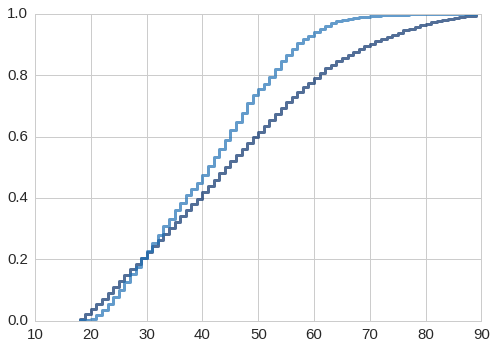

In [62]:
cdf1 = thinkstats2.Cdf(recent.age)
cdf2 = thinkstats2.Cdf(updated.age)
thinkplot.Cdfs([cdf1, cdf2])

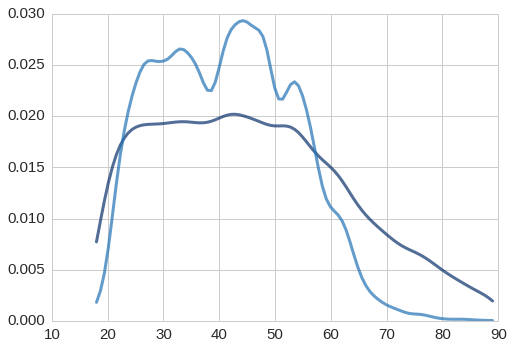

In [63]:
pdf1 = thinkstats2.EstimatedPdf(recent.age)
pdf2 = thinkstats2.EstimatedPdf(updated.age)
thinkplot.Pdfs([pdf1, pdf2])

In [64]:
xs = np.arange(17, 92, 1)
xs

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91])

##  Modeling

In [65]:
def center_factors(df):
    df['cohort66'] = df.cohort - 1966
    df['cohort662'] = df.cohort66**2

In [66]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,cohort5,none,cath,prot,other,relig2,age_group10,year4,cohort66,cohort662
0,1972,0,0,1895.0,77.0,1.3339,0,1.0,5,659,...,1897.5,0,0,1,0,1.0,70.0,1970,-71.0,5041.0
1,1972,0,0,1909.0,63.0,0.8893,0,1.0,8,1531,...,1907.5,0,0,1,0,1.0,60.0,1970,-57.0,3249.0
2,1972,0,0,1949.0,23.0,0.8893,0,1.0,16,1250,...,1947.5,0,0,1,0,1.0,20.0,1970,-17.0,289.0
3,1972,0,0,1943.0,29.0,0.4446,0,1.0,13,599,...,1942.5,0,0,1,0,1.0,20.0,1970,-23.0,529.0
4,1972,0,0,1907.0,65.0,1.3339,0,1.0,6,1196,...,1907.5,0,0,1,0,1.0,60.0,1970,-59.0,3481.0


In [67]:
formula = 'prot ~ cohort66 + cohort662'
results1 = smf.logit(formula, data=sample).fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.664818
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 May 2017   Pseudo R-squ.:                 0.02195
Time:                        15:44:40   Log-Likelihood:                -41215.
converged:                       True   LL-Null:                       -42140.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0646      0.010      6.177      0.000       0.044       0.085
cohort66      -0.0207      0.001    -28.725      0.000      -0.022      -0.019
cohort662  -9.718e-05   1.59e-05     -6.118      0.000      -0.000    -6.6e-05
==============================================================================
"""

In [68]:
formula = 'cath ~ cohort66 + cohort662'
results2 = smf.logit(formula, data=sample).fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.569679
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 May 2017   Pseudo R-squ.:               0.0009282
Time:                        15:44:40   Log-Likelihood:                -35317.
converged:                       True   LL-Null:                       -35350.
                                        LLR p-value:                 5.631e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0062      0.012    -85.782      0.000      -1.029      -0.983
cohort66      -0.0001      0.001     -0.169      0.866      -0.002       0.001
cohort662  -8.128e-05   1.76e-05     -4.625      0.000      -0.000   -4.68e-05
==============================================================================
"""

In [69]:
formula = 'other ~ cohort66 + cohort662'
results3 = smf.logit(formula, data=sample).fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.224504
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 May 2017   Pseudo R-squ.:                 0.01781
Time:                        15:44:41   Log-Likelihood:                -13918.
converged:                       True   LL-Null:                       -14171.
                                        LLR p-value:                2.351e-110
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.5043      0.020   -124.391      0.000      -2.544      -2.465
cohort66       0.0205      0.001     16.221      0.000       0.018       0.023
cohort662   5.549e-05    3.3e-05      1.682      0.093   -9.19e-06       0.000
==============================================================================
"""

In [70]:
formula = 'none ~ cohort66 + cohort662'
results4 = smf.logit(formula, data=sample).fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.335500
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61992
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 May 2017   Pseudo R-squ.:                 0.05934
Time:                        15:44:41   Log-Likelihood:                -20799.
converged:                       True   LL-Null:                       -22111.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6694      0.015   -109.864      0.000      -1.699      -1.640
cohort66       0.0351      0.001     37.663      0.000       0.033       0.037
cohort662   5.351e-05   2.77e-05      1.932      0.053   -7.79e-07       0.000
==============================================================================
"""

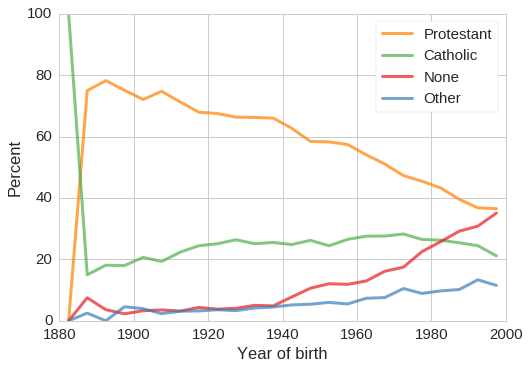

In [71]:
plot_grouped(grouped2)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

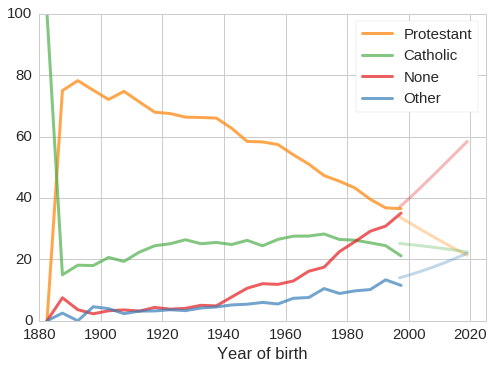

In [72]:
def make_pred(results):
    cohort = np.arange(1997, 2020)
    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = results.predict(df) * 100
    pred.index = cohort
    return pred


alpha = 0.3
series1 = make_pred(results1)
thinkplot.plot(series1, color=ORANGE, alpha=alpha)

series2 = make_pred(results2)
thinkplot.plot(series2, color=GREEN, alpha=alpha)

series3 = make_pred(results3)
thinkplot.plot(series3, color=BLUE, alpha=alpha)

series4 = make_pred(results4)
thinkplot.plot(series4, color=RED, alpha=alpha)

plot_grouped(grouped2)
thinkplot.config(xlabel='Year of birth', xlim=[1880, 2025])

## Generational replacement

In [84]:
COLUMNS = ['prot', 'cath', 'other', 'none']

def run_models(sample, result_seq, year):
    age = thinkstats2.Resample(sample.age)
    cohort = year - age
    print(np.mean(cohort<1997))
    df = pd.DataFrame(dict(cohort=cohort))
    center_factors(df)
    pred = [results.predict(df).mean() for results in result_seq]
    return pd.Series(pred, index=COLUMNS)

In [79]:
run_models(sample, [results1, results2, results3, results4], 2016)

0.976385192354


prot     0.481570
cath     0.262554
other    0.088754
none     0.203656
dtype: float64

In [80]:
run_models(sample, [results1, results2, results3, results4], 2023)

0.828937817566


prot     0.443500
cath     0.260424
other    0.102069
none     0.246477
dtype: float64

In [81]:
run_models(sample, [results1, results2, results3, results4], 2037)

0.545124606823


prot     0.365414
cath     0.251862
other    0.135202
none     0.347944
dtype: float64

In [82]:
run_models(sample, [results1, results2, results3, results4], 2053)

0.256569078151


prot     0.275910
cath     0.235330
other    0.187625
none     0.485947
dtype: float64

In [89]:
result_seq = [results1, results2, results3, results4]
df = pd.DataFrame(columns=COLUMNS)

for year in range(2016, 2050):
    df.loc[year] = run_models(sample, result_seq, year)

0.977030405678
0.958077264296
0.937575610936
0.919703201871
0.896394870554
0.873038148238
0.85290749254
0.834051133156
0.807597386886
0.788079683845
0.768094201145
0.7489152351
0.725848858779
0.702669570127
0.68087749012
0.664214856037
0.639003145415
0.618453101057
0.59932252601
0.581740462941
0.562626018227
0.541592063876
0.524719735463
0.503153480119
0.484861682394
0.462021130736
0.449487861924
0.427615130252
0.407129607226
0.391886442455
0.372771997742
0.358803129285
0.340301637229
0.322364706831


In [90]:
df

,prot,cath,other,none
2016,0.481226,0.262590,0.088834,0.203897
2017,0.475024,0.262342,0.090886,0.210548
2018,0.470783,0.262069,0.092389,0.215414
2019,0.465819,0.261865,0.094061,0.220792
2020,0.460926,0.261591,0.095780,0.226313
2021,0.454283,0.261162,0.098139,0.233918
2022,0.449319,0.260843,0.099930,0.239647
2023,0.443620,0.260447,0.101991,0.246256
2024,0.437979,0.259984,0.104141,0.253082
2025,0.432611,0.259552,0.106175,0.259528


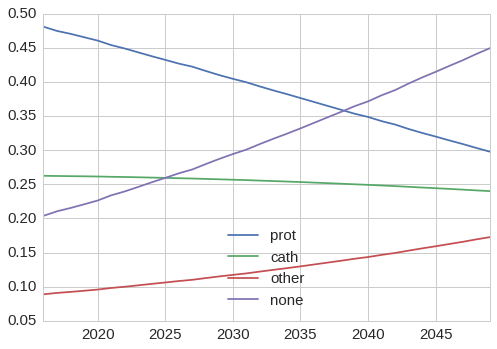

In [91]:
df.plot()